In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

from arch import arch_model
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [30]:
df_treasury = pd.read_csv("D-10-year treasury.csv")
df_treasury['DATE'] = pd.to_datetime(df_treasury['DATE'], errors='coerce')

# Drop rows where DGS10 has missing data
df_treasury = df_treasury.dropna(subset=['DGS10'])

# Convert DGS10 column to numeric, in case it's read as an object
df_treasury['DGS10'] = pd.to_numeric(df_treasury['DGS10'], errors='coerce')

# Resample to monthly data, taking the mean for each month
df_treasury = df_treasury.resample('M', on='DATE').mean()

# Rename the column
df_treasury = df_treasury.rename(columns={'DGS10': 'T-bond'})/12

# Reset index if you want DATE as a column instead of the index

df_treasury.index = df_treasury.index.to_period('M').to_timestamp()
df_treasury = df_treasury.reset_index()

df_treasury

,DATE,T-bond
0,1996-01-01,0.471032
1,1996-02-01,0.483792
2,1996-03-01,0.522381
3,1996-04-01,0.542614
4,1996-05-01,0.561402
...,...,...
341,2024-06-01,0.358772
342,2024-07-01,0.354053
343,2024-08-01,0.322576
344,2024-09-01,0.310292


In [3]:
df_ip = pd.read_csv("M-INDPRO.csv")
df_ip = df_ip.dropna(subset=['INDPRO'])
df_ip['DATE'] = pd.to_datetime(df_ip['DATE'], errors='coerce')
df_ip['INDPRO'] = pd.to_numeric(df_ip['INDPRO'], errors='coerce')
df_ip['INDPRO'] = np.log(df_ip['INDPRO'])
df_ip

,DATE,INDPRO
0,1996-01-01,4.284568
1,1996-02-01,4.298926
2,1996-03-01,4.297477
3,1996-04-01,4.307426
4,1996-05-01,4.315008
...,...,...
340,2024-05-01,4.635419
341,2024-06-01,4.636919
342,2024-07-01,4.630704
343,2024-08-01,4.634077


In [4]:
df_fed = pd.read_csv("M-FEDFUNDS.csv")
df_fed['DATE'] = pd.to_datetime(df_fed['DATE'], errors='coerce')

df_fed

,DATE,FEDFUNDS
0,1996-01-01,5.56
1,1996-02-01,5.22
2,1996-03-01,5.31
3,1996-04-01,5.22
4,1996-05-01,5.24
...,...,...
340,2024-05-01,5.33
341,2024-06-01,5.33
342,2024-07-01,5.33
343,2024-08-01,5.33


In [5]:
df_ff = pd.read_csv("M-F-F_Factors.CSV", header = 2)
df_ff= df_ff.iloc[:-100]
df_ff= df_ff.rename(columns={'Unnamed: 0': 'DATE'})
df_ff['DATE'] = pd.to_datetime(df_ff['DATE'].astype(str), format='%Y%m')
df_ff = df_ff[["DATE", "SMB", "HML"]]
df_ff

,DATE,SMB,HML
0,1926-07-01,-2.56,-2.43
1,1926-08-01,-1.17,3.82
2,1926-09-01,-1.40,0.13
3,1926-10-01,-0.09,0.70
4,1926-11-01,-0.10,-0.51
...,...,...,...
1173,2024-04-01,-2.39,-0.52
1174,2024-05-01,0.78,-1.66
1175,2024-06-01,-3.06,-3.31
1176,2024-07-01,6.80,5.73


In [6]:
df_apt = df_treasury.merge(df_ip, on = "DATE").merge(df_fed, on = "DATE").merge(df_ff, on = "DATE")
df_apt.set_index('DATE', inplace=True)
df_apt

,T-bond,INDPRO,FEDFUNDS,SMB,HML
DATE,,,,,
1996-01-01,5.652381,4.284568,5.56,-2.73,0.38
1996-02-01,5.805500,4.298926,5.22,1.79,-1.08
1996-03-01,6.268571,4.297477,5.31,1.49,0.35
1996-04-01,6.511364,4.307426,5.22,5.23,-4.02
1996-05-01,6.736818,4.315008,5.24,3.17,-0.83
...,...,...,...,...,...
2024-04-01,4.539091,4.628465,5.33,-2.39,-0.52
2024-05-01,4.482273,4.635419,5.33,0.78,-1.66
2024-06-01,4.305263,4.636919,5.33,-3.06,-3.31


In [7]:
import yfinance as yf
import pandas as pd

# Define ticker symbols for S&P 500 and S&P 500 Tech sector
tickers = {
    "sp500": "^GSPC",
    "sp500_tech": "^SP500-45"
}

# Specify the start date you want (e.g., '1998-01-01')
start_date = "1996-06-28"
end_date = None  # Set to None if you want to get data up to the current date

# Initialize an empty DataFrame to store merged data
merged_data = pd.DataFrame()

# Loop through each ticker and fetch the data
for name, ticker in tickers.items():
    # Download historical data
    data = yf.Ticker(ticker).history(start=start_date, end=end_date)
    
    # Keep only the 'Close' column and rename it to distinguish between the indices
    data = data[['Close']].rename(columns={'Close': f'Close_{name}'})
    
    # Convert the index to a datetime format and remove time zone
    data.index = pd.to_datetime(data.index).tz_localize(None)
    
    # Merge the data based on the Date index
    if merged_data.empty:
        merged_data = data
    else:
        merged_data = merged_data.join(data, how='outer')

monthly_data = merged_data.resample('M').mean()
monthly_data.index = monthly_data.index.to_period('M').to_timestamp()
monthly_data.reset_index(inplace=True)
monthly_data = monthly_data.rename(columns={'Date': 'DATE'})

monthly_data

,DATE,Close_sp500,Close_sp500_tech
0,1996-06-01,670.630005,159.832275
1,1996-07-01,644.070454,150.367728
2,1996-08-01,662.682279,159.763641
3,1996-09-01,674.885498,168.414360
4,1996-10-01,701.455654,177.786189
...,...,...,...
337,2024-07-01,5538.004572,4383.863581
338,2024-08-01,5478.214577,4186.788175
339,2024-09-01,5621.260449,4244.798511
340,2024-10-01,5792.319548,4469.678668


In [8]:
from pandas_datareader.fred import FredReader

fred_indicators = ['CPIAUCSL']


df = FredReader(symbols=fred_indicators, start='1900', end=None).read()

rename_dict = {'CPIAUCSL':'CPI'}
df = df.rename(columns=rename_dict)
df['CPI'] = np.log(df['CPI'])
df

,CPI
DATE,
1947-01-01,3.067122
1947-02-01,3.073619
1947-03-01,3.091042
1947-04-01,3.091042
1947-05-01,3.088767
...,...
2024-05-01,5.746922
2024-06-01,5.746360
2024-07-01,5.747908


In [9]:
df_apt = df_apt.merge(df, on = "DATE").merge(monthly_data, on="DATE")
df_apt.set_index('DATE', inplace=True)

for column in df_apt.columns:
    df_apt[column] = pd.to_numeric(df_apt[column], errors='coerce')
df_apt = df_apt.dropna()

df_apt.index = pd.to_datetime(df_apt.index)  # Ensure index is datetime

In [10]:
df_apt = df_apt.asfreq('MS')
df_apt

,T-bond,INDPRO,FEDFUNDS,SMB,HML,CPI,Close_sp500,Close_sp500_tech
DATE,,,,,,,,
1996-06-01,6.912000,4.322444,5.27,-4.01,2.35,5.054333,670.630005,159.832275
1996-07-01,6.865455,4.322460,5.40,-4.31,5.14,5.056246,644.070454,150.367728
1996-08-01,6.635455,4.327514,5.22,2.44,-0.74,5.057519,662.682279,159.763641
1996-09-01,6.832000,4.333758,5.30,-0.98,-2.72,5.060694,674.885498,168.414360
1996-10-01,6.533636,4.333567,5.24,-4.44,4.94,5.063860,701.455654,177.786189
...,...,...,...,...,...,...,...,...
2024-04-01,4.539091,4.628465,5.33,-2.39,-0.52,5.746864,5112.492742,3698.169067
2024-05-01,4.482273,4.635419,5.33,0.78,-1.66,5.746922,5235.225497,3873.035434
2024-06-01,4.305263,4.636919,5.33,-3.06,-3.31,5.746360,5415.140497,4271.982589


In [11]:
# Step 1: Function to Check for Stationarity
def check_stationarity(series, name):
    result = adfuller(series)
    print(f'{name} ADF Statistic: {result[0]}')
    print(f'{name} p-value: {result[1]}')
    if result[1] <= 0.05:
        print(f"{name} Series is stationary\n")
    else:
        print(f"{name} Series is non-stationary\n")
        return False
    return True

# Step 2: Check stationarity for each relevant column
factors = ['FEDFUNDS', 'INDPRO', 'SMB', 'HML', 'CPI']

stationary_results = {}
for factor in factors:
    stationary_results[factor] = check_stationarity(df_apt[factor], factor)

# Step 3: Apply Differencing if Non-Stationary
for factor in factors:
    if not stationary_results[factor]:  # If the series is non-stationary
        df_apt[factor + '_diff'] = df_apt[factor].diff().dropna()  # Differencing the series
        # Check stationarity again on the differenced series
        print(f"Checking stationarity for differenced {factor}:")
        check_stationarity(df_apt[factor + '_diff'].dropna(), factor + '_diff')

FEDFUNDS ADF Statistic: -2.6849320938153607
FEDFUNDS p-value: 0.07668216544526446
FEDFUNDS Series is non-stationary

INDPRO ADF Statistic: -3.0694600014487525
INDPRO p-value: 0.028897400828873324
INDPRO Series is stationary

SMB ADF Statistic: -8.261350420412114
SMB p-value: 5.073341851095029e-13
SMB Series is stationary

HML ADF Statistic: -11.232387748792332
HML p-value: 1.893371390512455e-20
HML Series is stationary

CPI ADF Statistic: 0.6455748981009135
CPI p-value: 0.9886867285374885
CPI Series is non-stationary

Checking stationarity for differenced FEDFUNDS:
FEDFUNDS_diff ADF Statistic: -4.191898332804267
FEDFUNDS_diff p-value: 0.0006800185732982863
FEDFUNDS_diff Series is stationary

Checking stationarity for differenced CPI:
CPI_diff ADF Statistic: -4.589767916502526
CPI_diff p-value: 0.00013489663864185022
CPI_diff Series is stationary



In [12]:
df_apt['INDPRO_diff'] = df_apt['INDPRO'].diff().dropna()
adf_result = adfuller(df_apt['INDPRO_diff'].dropna())

adf_statistic = adf_result[0]
p_value = adf_result[1]

print(f'ADF Statistic: {adf_statistic}')
print(f'p-value: {p_value}')

ADF Statistic: -13.801337250466814
p-value: 8.560259083333163e-26


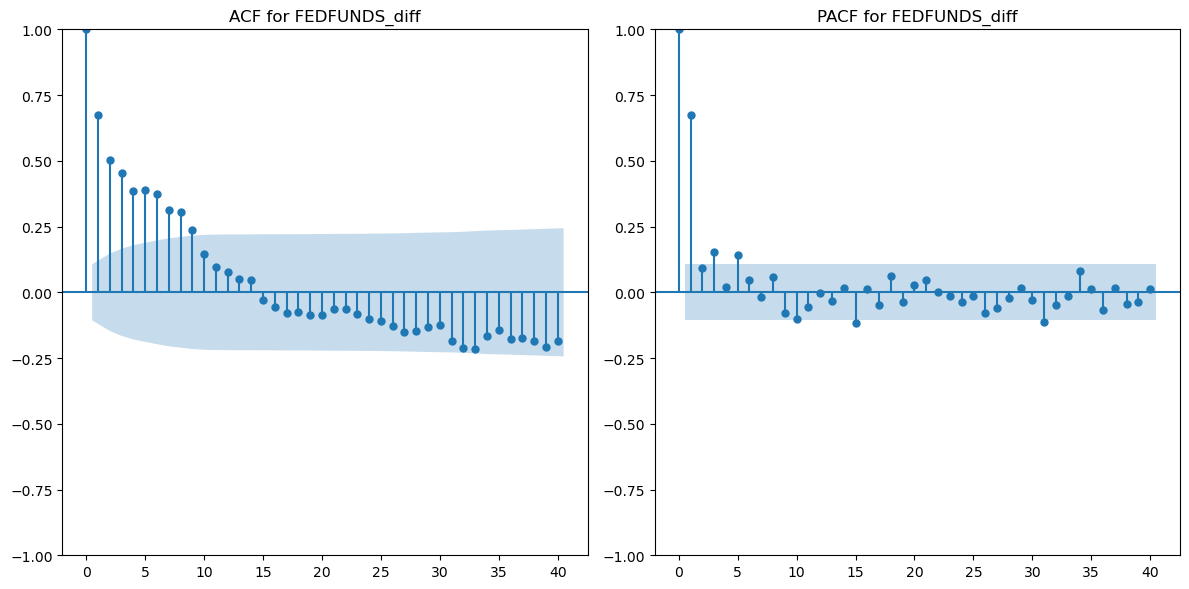

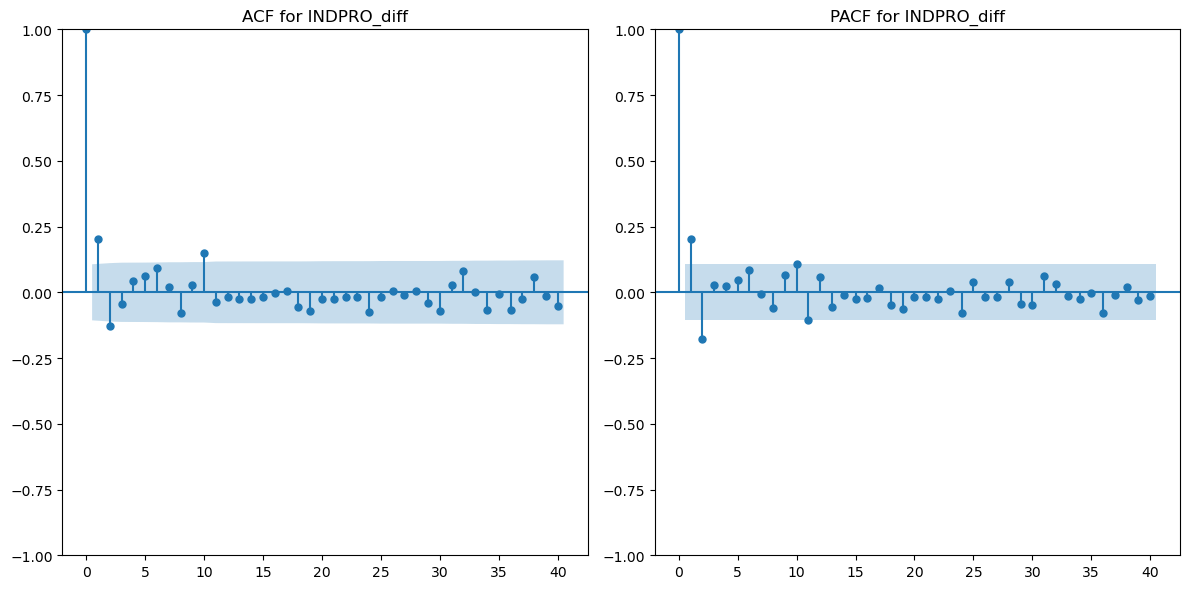

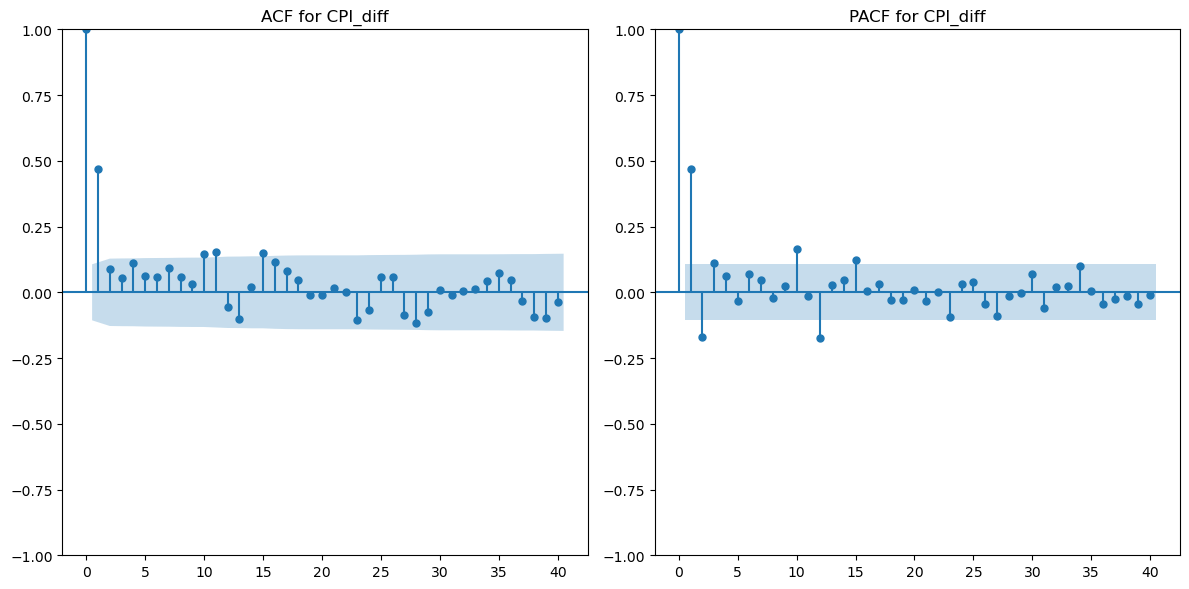

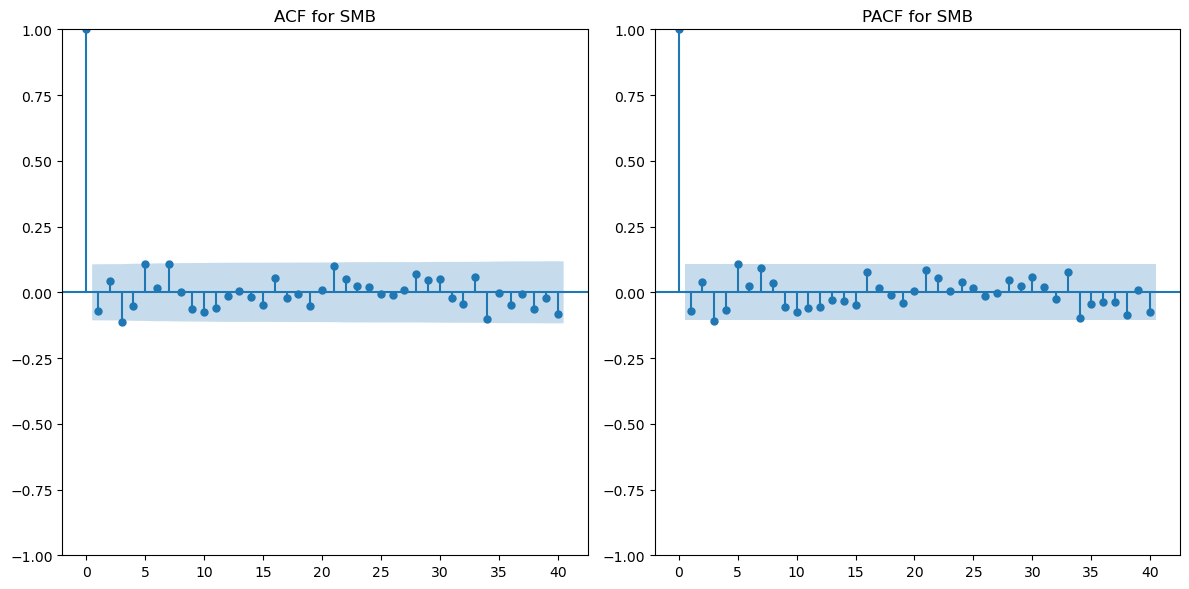

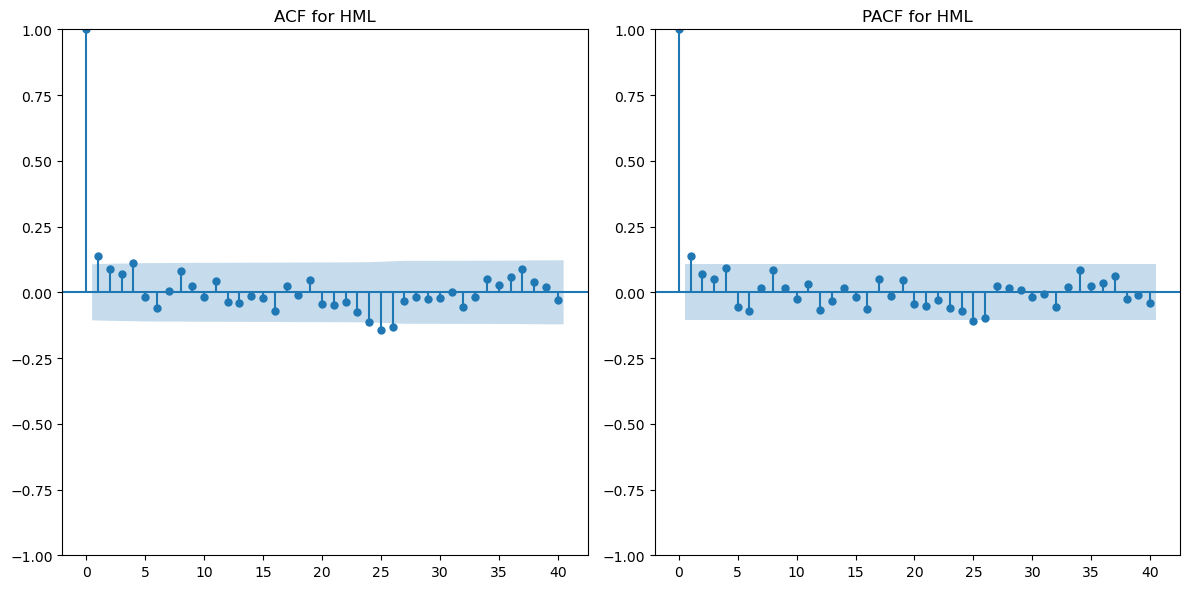

In [13]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

for factor in ['FEDFUNDS_diff', 'INDPRO_diff', 'CPI_diff', 'SMB', 'HML']:
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plot_acf(df_apt[factor].dropna(), lags=40, ax=plt.gca())
    plt.title(f'ACF for {factor}')
    
    plt.subplot(1, 2, 2)
    plot_pacf(df_apt[factor].dropna(), lags=40, ax=plt.gca())
    plt.title(f'PACF for {factor}')
    
    plt.tight_layout()
    plt.show()

In [36]:
# Define the orders you want to try
orders = {
    'FEDFUNDS_diff': (1, 1, 9),  # Adjust based on ACF/PACF plots
    'INDPRO_diff': (2, 1, 1),     # Adjust based on ACF/PACF plots
    'CPI_diff': (2, 1, 1),         # Adjust based on ACF/PACF plots
    'SMB': (0, 0, 0),              # Original series
    'HML': (1, 0, 1)               # Original series
}

# Fit ARIMA models
model_fits = {}
for factor, order in orders.items():
    try:
        model = ARIMA(df_apt[factor].dropna(), order=order)
        model_fit = model.fit()
        print(f"Fitted ARIMA{order} for {factor}:")
        print(model_fit.summary())
        model_fits[factor] = model_fit
    except Exception as e:
        print(f"Error fitting model for {factor}: {e}")

/Users/wujiayi/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitted ARIMA(1, 1, 9) for FEDFUNDS_diff:
                               SARIMAX Results                                
Dep. Variable:          FEDFUNDS_diff   No. Observations:                  338
Model:                 ARIMA(1, 1, 9)   Log Likelihood                 215.215
Date:                Sat, 02 Nov 2024   AIC                           -408.430
Time:                        21:57:26   BIC                           -366.409
Sample:                    07-01-1996   HQIC                          -391.681
                         - 08-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8318      0.133      6.277      0.000       0.572       1.092
ma.L1         -1.2216      0.139     -8.784      0.000      -1.494      -0.949
ma.L2      

/Users/wujiayi/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [15]:
garch_model = arch_model(df_apt['INDPRO_diff'].dropna(), vol='Garch', p=2, q=0)
garch_fit = garch_model.fit()
print(garch_fit.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 7509.142312894887
Iteration:      2,   Func. Count:     14,   Neg. LLF: 106231.7909467276
Iteration:      3,   Func. Count:     20,   Neg. LLF: 1711.356010529943
Iteration:      4,   Func. Count:     26,   Neg. LLF: 2104.8958471176215
Iteration:      5,   Func. Count:     32,   Neg. LLF: 695.5129303018382
Iteration:      6,   Func. Count:     39,   Neg. LLF: 358.33834883366296
Iteration:      7,   Func. Count:     45,   Neg. LLF: 334.9420651051097
Iteration:      8,   Func. Count:     51,   Neg. LLF: 323.09244987123486
Iteration:      9,   Func. Count:     56,   Neg. LLF: 322.81951805370454
Iteration:     10,   Func. Count:     61,   Neg. LLF: 322.7030834787773
Iteration:     11,   Func. Count:     66,   Neg. LLF: 322.5274619780124
Iteration:     12,   Func. Count:     71,   Neg. LLF: 322.5255634386389
Iteration:     13,   Func. Count:     76,   Neg. LLF: 322.5255221645698
Iteration:     14,   Func. Count:     80,   Neg. LLF: 322.52

In [16]:
from arch import arch_model

# Try different orders for GARCH (p, q)
best_aic = np.inf
best_model = None
for p in range(1, 4):  # Example: testing p = 1, 2, 3
    for q in range(1, 3):  # Example: testing q = 1, 2
        try:
            model = arch_model(df_apt['INDPRO_diff'].dropna(), vol='Garch', p=p, q=q)
            model_fit = model.fit(disp="off")
            if model_fit.aic < best_aic:
                best_aic = model_fit.aic
                best_model = model_fit
        except:
            continue

print(best_model.summary())


                     Constant Mean - GARCH Model Results                      
Dep. Variable:            INDPRO_diff   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -322.526
Distribution:                  Normal   AIC:                           657.051
Method:            Maximum Likelihood   BIC:                           679.989
                                        No. Observations:                  338
Date:                Sat, Nov 02 2024   Df Residuals:                      337
Time:                        19:08:34   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.1798  2.969e-02      6.057  1.389e-09 [  0.122,  0.23

In [37]:
# Extract residuals from the fitted models
residuals = {}
for factor, model_fit in model_fits.items():
    residuals[factor] = model_fit.resid

# Convert residuals to a DataFrame
residuals_df = pd.DataFrame(residuals).dropna()
residuals_df.head()  # Check the first few rows of the residuals


,FEDFUNDS_diff,INDPRO_diff,CPI_diff,SMB,HML
DATE,,,,,
1996-07-01,0.130000,0.000016,0.001913,-4.35852,4.691122
1996-08-01,-0.310000,0.005038,-0.000640,2.39148,-1.695508
1996-09-01,0.186980,0.002657,0.001811,-1.02852,-3.204762
1996-10-01,-0.140070,-0.004133,0.000156,-4.48852,4.962999
1996-11-01,0.124511,0.007818,0.000480,-4.06852,0.745404


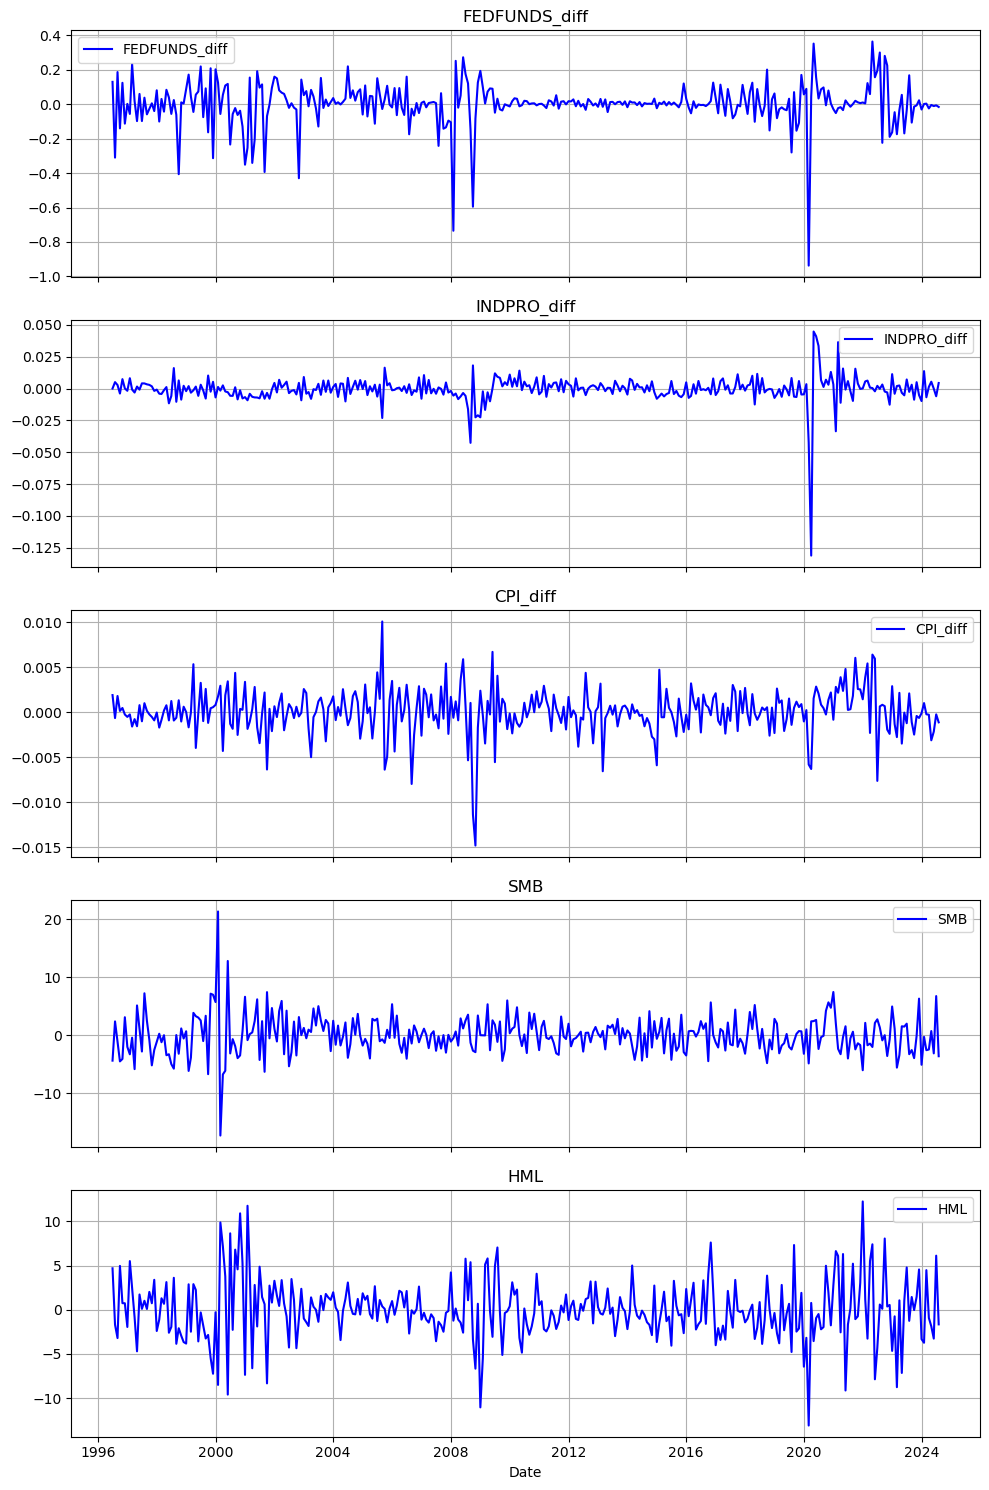

In [16]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(10, 15), sharex=True)

# Plot each column in a separate subplot
for ax, column in zip(axes, residuals_df.columns):
    ax.plot(residuals_df.index, residuals_df[column], label=column, color='b')
    ax.set_title(column)
    ax.grid(True)
    ax.legend()

# Set the common x-axis label
plt.xlabel('Date')
plt.tight_layout()
plt.show()

In [19]:
# Calculate returns
df_apt['Return_sp500'] = df_apt['Close_sp500'].pct_change()
df_apt['Return_sp500_tech'] = df_apt['Close_sp500_tech'].pct_change()
df_apt['Excess_Return_sp500'] = df_apt['Return_sp500'] - df_apt['T-bond']/12
df_apt['Excess_Return_sp500_tech'] = df_apt['Return_sp500_tech'] - df_apt['T-bond']/12

In [20]:
X = sm.add_constant(pd.DataFrame({
    'FEDFUNDS_diff': residuals_df['FEDFUNDS_diff'],
    'INDPRO_diff': residuals_df['INDPRO_diff'],
    'CPI_diff': residuals_df['CPI_diff'],
    'SMB': residuals_df['SMB'],
    'HML': residuals_df['HML']
}).dropna())

y = df_apt['Excess_Return_sp500'].dropna()

model_sp500 = sm.OLS(y, X).fit()
print(model_sp500.summary())

                             OLS Regression Results                            
Dep. Variable:     Excess_Return_sp500   R-squared:                       0.023
Model:                             OLS   Adj. R-squared:                  0.009
Method:                  Least Squares   F-statistic:                     1.598
Date:                 Sat, 02 Nov 2024   Prob (F-statistic):              0.160
Time:                         19:08:34   Log-Likelihood:                 207.84
No. Observations:                  338   AIC:                            -403.7
Df Residuals:                      332   BIC:                            -380.7
Df Model:                            5                                         
Covariance Type:             nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.2932      0.007 

In [21]:
X = sm.add_constant(pd.DataFrame({
    'FEDFUNDS_diff': residuals_df['FEDFUNDS_diff'],
    'INDPRO_diff': residuals_df['INDPRO_diff'],
    'CPI_diff': residuals_df['CPI_diff'],
    'SMB': residuals_df['SMB'],
    'HML': residuals_df['HML']
}).dropna())

y = df_apt['Excess_Return_sp500_tech'].dropna()

model_sp500_tech= sm.OLS(y, X).fit()
print(model_sp500_tech.summary())

                               OLS Regression Results                               
Dep. Variable:     Excess_Return_sp500_tech   R-squared:                       0.047
Model:                                  OLS   Adj. R-squared:                  0.033
Method:                       Least Squares   F-statistic:                     3.286
Date:                      Sat, 02 Nov 2024   Prob (F-statistic):            0.00654
Time:                              19:08:34   Log-Likelihood:                 193.70
No. Observations:                       338   AIC:                            -375.4
Df Residuals:                           332   BIC:                            -352.5
Df Model:                                 5                                         
Covariance Type:                  nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------

In [22]:
# Given data
R_f = 0.02  # Risk-Free Rate
betas_sp500 = {
    'FEDFUNDS': 0.2719,
    'INDPRO': -0.1374,
    'CPI': 0.2245,
    'SMB': -0.0002,
    'HML': -0.0383
}

betas_sp500_tech = {
    'FEDFUNDS': 0.2758,
    'INDPRO': -0.1375,
    'CPI': 0.2289,
    'SMB': 0.0015,
    'HML': -0.0417
}

# Expected risk premiums (example values)
risk_premiums = {
    'FEDFUNDS': 0.01,  # E(R_FEDFUNDS) - R_f
    'INDPRO': 0.00,    # E(R_INDPRO) - R_f
    'CPI': 0.005,      # E(R_CPI) - R_f
    'SMB': -0.005,     # E(R_SMB) - R_f
    'HML': -0.01       # E(R_HML) - R_f
}

# Function to calculate expected return
def expected_return(R_f, betas, risk_premiums):
    E_R = R_f  # Start with risk-free rate
    for factor, beta in betas.items():
        E_R += beta * risk_premiums[factor]
    return E_R

# Calculate expected returns
expected_return_sp500 = expected_return(R_f, betas_sp500, risk_premiums)
expected_return_sp500_tech = expected_return(R_f, betas_sp500_tech, risk_premiums)

# Print results
print(f"Expected Return of S&P 500: {expected_return_sp500:.4f} or {expected_return_sp500*100:.2f}%")
print(f"Expected Return of S&P 500 Tech: {expected_return_sp500_tech:.4f} or {expected_return_sp500_tech*100:.2f}%")

Expected Return of S&P 500: 0.0242 or 2.42%
Expected Return of S&P 500 Tech: 0.0243 or 2.43%


In [23]:
# List of assets and their corresponding returns (e.g., 'Close_sp500', 'Close_sp500_tech', etc.)
assets = ['Close_sp500', 'Close_sp500_tech']  # Add more assets as needed
factors = ['FEDFUNDS_diff', 'INDPRO_diff', 'CPI_diff', 'SMB', 'HML']

# Calculate excess returns
risk_free_rate = df_apt['T-bond']  # Use the appropriate column for the risk-free rate
excess_returns = {asset: df_apt[asset] - risk_free_rate for asset in assets}

# Store betas for each asset
betas = pd.DataFrame(index=assets, columns=factors)

# Estimate betas
for asset in assets:
    X = df_apt[factors]
    y = excess_returns[asset]
    X = sm.add_constant(X)  # Add a constant term for the intercept
    model = sm.OLS(y, X, missing='drop').fit()
    betas.loc[asset] = model.params[1:]  # Exclude the intercept

# Calculate lambda parameters
lambdas = {}
for factor in factors:
    # Prepare excess returns as a DataFrame
    excess_values = pd.DataFrame(excess_returns)

    # Ensure we take the dot product correctly
    lambdas[factor] = (excess_values.values @ betas[factor].astype(float)).mean()

# Display lambda parameters
lambda_df = pd.DataFrame(lambdas, index=['Lambda'])
print(lambda_df)


        FEDFUNDS_diff    INDPRO_diff      CPI_diff           SMB           HML
Lambda   2.419397e+06 -354104.336219  1.491430e+06 -57928.330913 -52190.710684


In [17]:
# Updated list of stock tickers
tickers = [
    "AAPL", "NVDA", "MSFT", "AMZN", "META", 
    "GOOGL", "BRK-B", "AVGO", "GOOG", "TSLA", 
    "LLY", "JPM", "XOM", "UNH", "V", 
    "MA", "HD", "PG", "COST", "JNJ", 
    "WMT", "ABBV", "NFLX", "BAC", "ORCL", 
    "CRM", "MRK", "KO", "CVX", "AMD", 
    "PEP", "ACN", "LIN", "CSCO", "WFC", 
    "MCD", "ADBE", "TMO", "PM", "ABT", 
    "IBM", "NOW", "GE", "TXN", "CAT", 
    "QCOM", "ISRG", "VZ", "DIS", "NEE", 
    "AMGN", "INTU", "RTX", "GS", "UBER", 
    "PFE", "CMCSA"
]

# Define the start date
start_date = '1996-06-28'

# Fetch historical data
data = yf.download(tickers, start=start_date, end=pd.Timestamp.today().strftime('%Y-%m-%d'))

# Extract the closing prices
closing_prices = data['Close']

# Drop columns with any NaN values
closing_prices = closing_prices.dropna(axis=1)

# Set the date as the index
closing_prices.index.name = 'DATE'


[*********************100%***********************]  57 of 57 completed


In [18]:
# Resample to monthly data and calculate the mean
monthly_mean_prices = closing_prices.resample('M').mean()

# Set the date as the index
monthly_mean_prices.index = monthly_mean_prices.index.to_period('M').to_timestamp()
monthly_mean_prices = monthly_mean_prices.drop(index=['2024-11-01', '2024-10-01'])
monthly_mean_prices

/var/folders/4v/7vr4zkl55559ntk9hqrs4r4m0000gn/T/ipykernel_15924/3533813958.py:5: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  monthly_mean_prices.index = monthly_mean_prices.index.to_period('M').to_timestamp()


Ticker,AAPL,ABT,ADBE,AMD,AMGN,BAC,BRK-B,CAT,CMCSA,COST,...,PG,QCOM,RTX,TMO,TXN,UNH,VZ,WFC,WMT,XOM
DATE,,,,,,,,,,,,,,,,,,,,,
1996-06-01,0.187500,9.763594,4.484375,6.812500,13.500000,20.656250,20.660000,16.937500,3.062500,10.812500,...,22.656250,3.320313,9.046570,41.625000,6.234375,6.312500,28.665913,8.718750,4.229167,21.718750
1996-07-01,0.177329,9.783999,4.097301,6.088068,13.553267,20.551847,20.860909,16.755682,2.609848,10.244318,...,21.742898,2.803267,8.672014,37.937500,5.705966,4.743608,27.056330,8.420455,3.996212,21.544744
1996-08-01,0.205300,10.362979,4.213068,6.517045,14.479403,22.710227,21.119091,17.500000,2.588542,10.383523,...,22.458807,2.860085,9.065343,39.454545,5.825284,4.801136,26.650102,9.392045,4.352273,20.605114
1996-09-01,0.200614,10.667007,4.371094,6.862500,14.935937,21.200000,21.400000,18.326563,2.655208,10.325000,...,23.073438,2.527539,9.232910,39.243750,6.242188,5.134375,25.956703,9.896875,4.440625,21.176562
1996-10-01,0.216833,11.349385,4.439878,8.345109,15.434783,22.414402,21.454782,18.131793,2.457427,10.296196,...,24.229620,2.392493,9.772091,38.135870,6.596467,4.835598,27.158081,10.667120,4.493659,21.904891
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-01,186.285909,104.199090,478.983182,158.788636,305.354093,38.587727,408.558180,348.319545,38.924091,783.259546,...,165.439545,192.172273,104.680909,581.874093,190.793636,505.888179,39.809092,60.550454,62.466363,116.549091
2024-06-01,206.263158,104.744737,495.404732,161.010000,307.381054,39.570527,409.605792,327.804737,38.386842,848.574739,...,166.985788,209.295788,105.040000,568.242110,195.160526,493.104211,40.608421,58.116842,67.231578,112.388422
2024-07-01,224.598637,103.752273,556.158189,160.942728,326.384091,41.739545,426.948638,340.420000,38.942273,846.800909,...,166.155909,194.285910,105.122727,558.401811,201.079090,534.448638,40.823182,59.626364,69.724546,115.177273


In [42]:
returns = monthly_mean_prices.pct_change().dropna()*100
risk_free_rate = df_apt['T-bond']/12
excess_returns = returns.sub(risk_free_rate, axis=0).dropna()
excess_returns

Ticker,AAPL,ABT,ADBE,AMD,AMGN,BAC,BRK-B,CAT,CMCSA,COST,...,PG,QCOM,RTX,TMO,TXN,UNH,VZ,WFC,WMT,XOM
DATE,,,,,,,,,,,,,,,,,,,,,
1996-07-01,-5.996848,-0.363131,-9.203733,-11.205983,-0.177551,-1.077554,0.400335,-1.645586,-15.352580,-5.826982,...,-4.603469,-16.144318,-4.712433,-9.430980,-9.047856,-25.425857,-6.187093,-3.993431,-6.080414,-1.373298
1996-08-01,15.220840,5.364668,2.272491,6.493242,6.280353,9.949171,0.684679,3.889229,-1.369355,0.805892,...,2.739657,1.473900,3.982660,3.445847,1.538158,0.659802,-2.054371,10.985507,8.356999,-4.914253
1996-09-01,-2.851938,2.364461,3.181511,4.731451,2.583656,-7.219321,0.760786,4.153881,2.006121,-1.132945,...,2.167369,-12.196474,1.279107,-1.103608,6.587458,6.371495,-3.171193,4.805742,1.460694,2.204002
1996-10-01,7.540372,5.852620,1.029140,21.060029,2.795429,5.183842,-0.288476,-1.607239,-7.993259,-0.823446,...,4.466409,-5.887448,5.295306,-3.367545,5.131103,-6.363623,4.083921,7.238235,0.649828,2.894846
1996-11-01,2.721845,5.373504,7.321371,34.329982,-4.665081,8.209158,2.126808,3.090745,9.014910,4.861754,...,9.117692,9.315495,7.127293,-5.429329,4.048938,9.280722,1.371805,3.570404,-5.730640,3.184180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-01,-2.168656,-6.513578,-10.689293,-15.636451,-2.561896,1.841704,-0.594874,3.581839,-6.864657,-3.317141,...,-1.961523,-0.603273,8.040265,-3.312565,-1.566986,-3.508617,0.232573,1.738357,-1.652967,7.990221
2024-05-01,9.461924,-4.742932,-0.545088,-2.863914,12.529751,3.965060,-0.192070,-4.023566,-3.025684,8.646740,...,4.002045,14.032997,3.575022,2.086646,12.026027,6.848925,-2.162140,3.463127,4.082897,-3.175277
2024-06-01,10.365200,0.164885,3.069647,1.040172,0.305035,2.188149,-0.102355,-6.248424,-1.739019,7.980123,...,0.575855,8.551731,-0.015738,-2.701544,1.930031,-2.885806,1.649135,-4.377920,7.269677,-3.928658


In [47]:
beta = pd.DataFrame(index=residuals_df.columns, columns=excess_returns.columns)

for stock in excess_returns.columns:
    y = excess_returns[stock]
    X = residuals_df.copy()
    X = sm.add_constant(X)
    model = sm.OLS(y, X, missing='drop').fit()
    beta[stock] = model.params
    
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    XOM   R-squared:                       0.137
Model:                            OLS   Adj. R-squared:                  0.124
Method:                 Least Squares   F-statistic:                     10.56
Date:                Sat, 02 Nov 2024   Prob (F-statistic):           2.02e-09
Time:                        22:39:17   Log-Likelihood:                -1003.2
No. Observations:                 338   AIC:                             2018.
Df Residuals:                     332   BIC:                             2041.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.3050      0.259      1.175

In [44]:
average_excess_returns = excess_returns.mean()
df_risk_premuim = pd.DataFrame(average_excess_returns)
df_risk_premuim

,0
Ticker,
AAPL,2.358072
ABT,0.537320
ADBE,1.524421
AMD,1.789586
AMGN,0.855247
BAC,0.296210
BRK-B,0.711836
CAT,0.858585
CMCSA,0.659300


In [45]:
beta_t = beta.T
beta_t

,FEDFUNDS_diff,INDPRO_diff,CPI_diff,SMB,HML
Ticker,,,,,
AAPL,8.220762,36.213289,568.898322,0.514337,-0.290905
ABT,1.332115,-51.357056,38.496440,-0.025014,0.079217
ADBE,7.129313,20.529833,271.981258,0.608069,-0.328270
AMD,1.647555,-53.916936,592.476376,0.839254,-0.047179
AMGN,8.801101,-52.795144,-7.065041,0.139489,-0.082606
BAC,0.685470,56.104303,349.108042,0.552228,0.829775
BRK-B,0.489024,45.249205,-22.317594,-0.004061,0.359960
CAT,2.559604,-13.760897,580.829747,0.359964,0.553827
CMCSA,-0.576126,45.789453,-18.093291,0.386298,0.007396


In [49]:
correlation_matrix = beta_t.corr()
print(correlation_matrix)

               FEDFUNDS_diff  INDPRO_diff  CPI_diff       SMB       HML
FEDFUNDS_diff       1.000000    -0.224400  0.048450 -0.066435 -0.438377
INDPRO_diff        -0.224400     1.000000  0.047789  0.169821  0.482597
CPI_diff            0.048450     0.047789  1.000000  0.601124  0.024813
SMB                -0.066435     0.169821  0.601124  1.000000 -0.086514
HML                -0.438377     0.482597  0.024813 -0.086514  1.000000


In [46]:
X = beta_t
X = sm.add_constant(X)
model = sm.OLS(df_risk_premuim, X, missing='drop').fit()
lambda_estimates = pd.DataFrame(model.params, columns=['Lambda Estimates'])

lambda_estimates

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      0   R-squared:                       0.545
Model:                            OLS   Adj. R-squared:                  0.477
Method:                 Least Squares   F-statistic:                     7.919
Date:                Sat, 02 Nov 2024   Prob (F-statistic):           5.45e-05
Time:                        22:14:39   Log-Likelihood:                -12.340
No. Observations:                  39   AIC:                             36.68
Df Residuals:                      33   BIC:                             46.66
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.4488      0.117      3.833